In [16]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("../feature_engineering_model/featured_datasets/final_data_featured_1.csv")
df_label = pd.read_csv("../data_gpt_labeler/labeled_datasets/final_data_labeled_1.csv")

In [3]:
df_concat = pd.concat([df,df_label], axis=1)
df_final = df_concat[["A","B","D2","E","G","policy_label"]].copy()
df_final

,A,B,D2,E,G,policy_label
0,0.126823,0.581653,0.660104,0.993421,0.999407,1
1,0.066522,0.565305,0.620909,0.360918,0.997275,1
2,0.158263,0.575038,0.551840,0.987322,0.999049,1
3,0.062633,0.575837,0.630236,0.859828,0.999422,1
4,0.005904,0.572793,0.792418,0.901759,0.999557,1
...,...,...,...,...,...,...
9995,0.353107,0.584095,0.609373,0.986010,0.999477,1
9996,0.407681,0.572810,0.561827,0.803679,0.999491,1
9997,0.129818,0.583600,0.596096,0.905910,0.999499,1
9998,0.024677,0.561784,0.500000,0.767955,0.999611,1


In [4]:
#undersampling
# df_zero = df_final[df_final["policy_label"]==0].copy()
# df_one = df_final[df_final["policy_label"]==1].sample(len(df_zero)).copy()
# df_init = pd.concat([df_zero, df_one])
# df_init

In [5]:
X = df_final[["A","B","D2","E","G"]]
y = df_final.policy_label

In [6]:
# stratified train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# calculate class_weight
# classes = np.unique(y_train)
# class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
# class_weight_dict = dict(zip(classes, class_weights))
# print("Class weights:", class_weight_dict)

In [7]:
#oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42) 
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [23]:
# MLP model
model = Sequential([
    Input(shape=(5,)),
    
    Dense(64),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(32),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=
              [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
                ])

In [24]:
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True,
    min_delta=0.00001
)

In [25]:
# training
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    #class_weight=class_weight_dict,
    verbose=1,
    #callbacks=[early_stop]
)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5863 - loss: 0.6954 - precision: 0.5637 - recall: 0.7645 - val_accuracy: 0.8745 - val_loss: 0.6347 - val_precision: 0.8997 - val_recall: 0.9669
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.5974 - loss: 0.6758 - precision: 0.5741 - recall: 0.7545 - val_accuracy: 0.7975 - val_loss: 0.6144 - val_precision: 0.9211 - val_recall: 0.8451
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.6060 - loss: 0.6709 - precision: 0.5829 - recall: 0.7454 - val_accuracy: 0.7725 - val_loss: 0.5893 - val_precision: 0.9289 - val_recall: 0.8064
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.6244 - loss: 0.6571 - precision: 0.5988 - recall: 0.7541 - val_accuracy: 0.7530 - val_loss: 0.5889 - val_precision: 0.9328 - val_recall: 0.7789
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6254 - loss: 0.6557 - precision: 0.6027 - recall: 0.7361 - val_accuracy: 0.7460 -

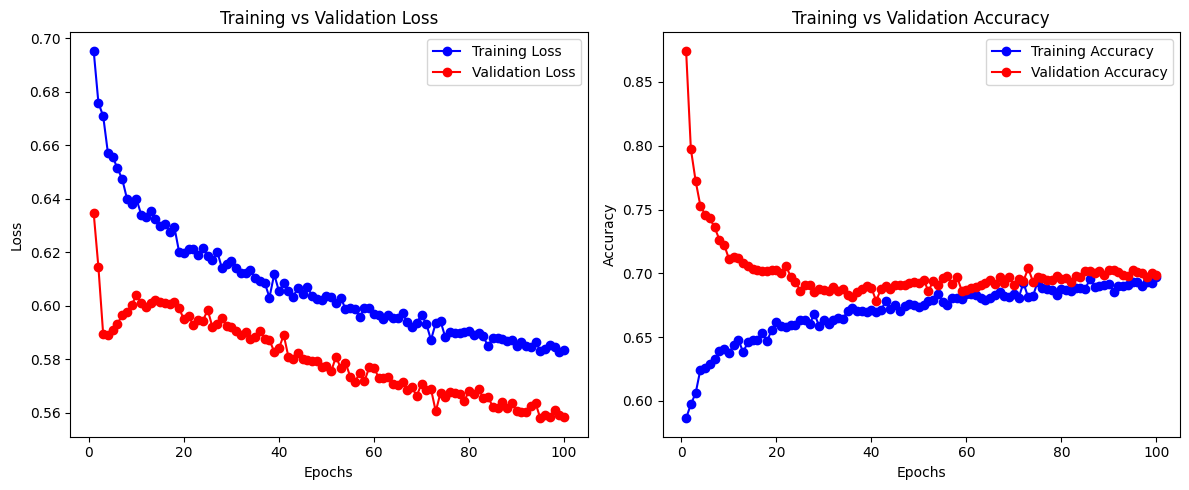

In [26]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Loss Graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
y_val_pred_probs = model.predict(X_val)
y_val_pred = (y_val_pred_probs > 0.5).astype(int)

f1_val = f1_score(y_val, y_val_pred)
print("Validation F1-score:", f1_val)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
Validation F1-score: 0.8054211035818006
